In [22]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from sympy import conjugate
from torch.autograd import Variable
import torch
from rsvg import rsvg
from rdmg import rdm_ginibre
import pennylane as qml
import matplotlib.pyplot as plt

import numpy as np
#def bloch_sphere(circuit):
#    state = Statevector(circuit)
#    return plot_bloch_multivector(state)

#def inner_product(v,w):
#    d = len(v); ip = 0
#    for j in range(0,d):
#        ip += conjugate(v[j])*w[j]
#    return ip

def gen_paulis(d):
    Paulis = Variable(torch.zeros([3*d, 2, 2], dtype=torch.complex128), requires_grad=False)
    aux = 0
    for i in range(0,d,3):
        Paulis[i+aux] = torch.tensor([[0, 1], [1, 0]])        
        Paulis[i+1+aux] = torch.tensor([[0, -1j], [1j, 0]])
        Paulis[i+2+aux] = torch.tensor([[1, 0], [0, -1]])
        aux += 2
    return Paulis

def init_state_fidelity(d):
    target_state = rsvg(d)
    target_op = np.outer(target_state.conj(), target_state)
    target_op = torch.tensor(target_op)
    return target_op

def multi_state_fidelity(n_qb):
    d = 2**n_qb
    target_state = rdm_ginibre(d)
    print(np.trace(np.dot(target_state,target_state)))
    target_op = torch.tensor(target_state)
    return target_op

def init_state_exp_val(d):
    rrho = rdm_ginibre(2)
    Paulis = gen_paulis(d)
    target_vector = [np.trace(np.real(np.dot(rrho,i))) for i in Paulis]
    target_vector = Variable(torch.tensor(target_vector ))
    return target_vector

def get_device(n_qubit):
    device = qml.device('qiskit.aer', wires=n_qubit, backend='qasm_simulator')
    return device

def random_params(n):
    params = np.random.normal(0,np.pi/2, n)
    params = Variable(torch.tensor(params), requires_grad=True)
    return params



(0.41129976977341+0j)


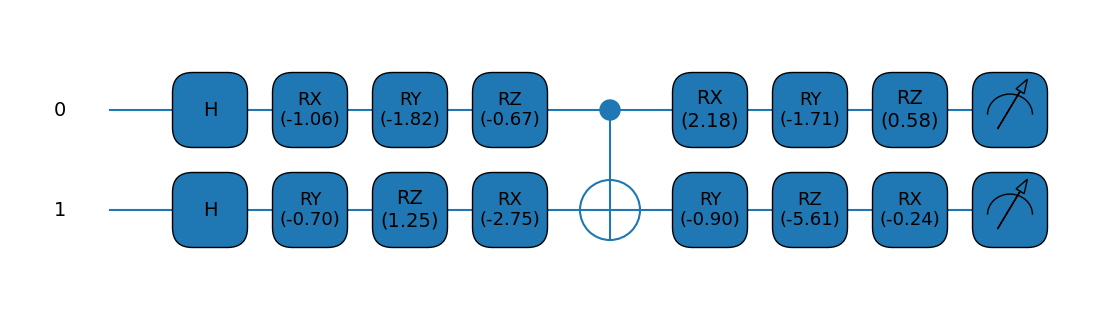

In [24]:
n_qubits = 2
n = 12
alpha = multi_state_fidelity(2)
device = get_device(n_qubits)
params = random_params(n)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return qml.expval(qml.Hermitian(M, wires=[0,1]))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

In [25]:
def cost(params, alpha):
    L = (1-(circuit(params, M=alpha)))**2
    return L

In [33]:
def train(epocas, params, alpha):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params, alpha)
    best_params = 1*params
    for epoch in range(epocas):
        opt.zero_grad()
        loss = cost(params, alpha)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    return best_params

best_params = train(30, params, alpha)


0 0.2038215888471093
1 0.21259456931511056
2 0.20788428972411876
3 0.20611788613721754
4 0.2042953408873275
5 0.20648956122343123
6 0.2066345789340954


KeyboardInterrupt: 

In [32]:
def fidelidade(target_op):
    return circuit(best_params, M=target_op).item()
print(fidelidade(alpha))


0.5477305931857004


In [29]:
print(alpha)

tensor([[ 0.2586+0.0000j,  0.0160-0.0204j, -0.0309-0.0119j,  0.0608-0.0425j],
        [ 0.0160+0.0204j,  0.2516+0.0000j,  0.1169+0.2075j,  0.0147+0.0236j],
        [-0.0309+0.0119j,  0.1169-0.2075j,  0.3451+0.0000j, -0.0266-0.0713j],
        [ 0.0608+0.0425j,  0.0147-0.0236j, -0.0266+0.0713j,  0.1448+0.0000j]],
       dtype=torch.complex128)


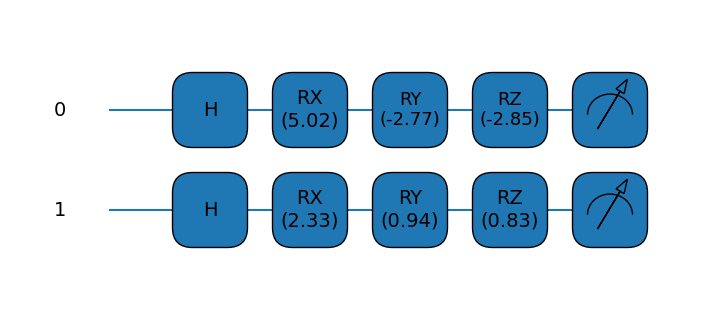

In [8]:

n_qubits = 2
device, params = device_and_random_params(n_qubits)
target_vector = init_state_exp_val(n_qubits)
@qml.qnode(device, interface="torch")
# def circuit(params, M=None):
#     qml.Hadamard(wires=0)
#     qml.RX(params[0], wires=0)
#     qml.RY(params[0], wires=0)
#     qml.RZ(params[0], wires=0)
#     qml.Hadamard(wires=1)
#     qml.RX(params[1], wires=1)
#     qml.RY(params[1], wires=1)
#     qml.RZ(params[1], wires=1)
#     return qml.expval(qml.Hermitian(M, wires=[0,1]))
# drawer = qml.draw(circuit)

def circuit(n_qubits, params, M=None):
    aux=0
    w = []
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RX(params[i+aux], wires=i)
        qml.RY(params[i+1+aux], wires=i)
        qml.RZ(params[i+2+aux], wires=i)
        w.append(i)
        aux+=2
    #qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian(M, wires=w))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(n_qubits, params,target_vector)
plt.show()

In [3]:
print(type(params))
print(len(params))
print(len(target_vector))
print(len(gen_paulis(2)))
print(np.shape(params))

<class 'torch.Tensor'>
3
3
6
torch.Size([3])


In [5]:
def cost(params, target_vector):
    size = len(params)
    Paulis = gen_paulis(2)
    L = 0
    for k in range(size):
        #print(k)
        L += torch.abs(circuit(n_qubits, params, Paulis[k]) - target_vector[k])
    return L
def train(epocas, params, target_vector):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params, target_vector)
    best_params = 1*params
    for epoch in range(epocas):
        opt.zero_grad()
        loss = cost(params, target_vector)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    return best_params

best_params = train(30, params, target_vector)

0 0.7001682822876808
1 0.6220432822876807
2 0.5568120431742778
3 0.5294682931742778
4 0.5763432931742778
5 0.47673391817427785
6 0.42985891817427785
7 0.49040579317427785
8 0.5439182822876807
9 0.40134015728768074
10 0.49509015728768074
11 0.40134015728768074
12 0.37399640728768074
13 0.39938703228768074
14 0.36032453228768074
15 0.13571515728768074
16 0.18454328228768074
17 0.14274954317427785
18 0.05759015728768074
19 0.08791578850954268
20 0.19260642439613979
21 0.14963767439613979
22 0.17092546771231926
23 0.24924704939613979
24 0.20041892439613979
25 0.17307517439613979
26 0.14768454939613979
27 0.10862204939613979
28 0.05290579317427785
29 0.059793924396139786


In [5]:
print(best_params)

NameError: name 'best_params' is not defined

In [1]:
from multi_pure_prep import init_state_exp_val
from multi_pure_prep import train,gen_paulis
from multi_pure_prep import device_and_random_params
from multi_pure_prep import cost,circuit
import pennylane as qml


ModuleNotFoundError: No module named 'torch'

In [10]:
target_vector = init_state_exp_val(2)
device, params = device_and_random_params()
qc = circuit(params, target_vector)
#qnode = qml.QNode(qc, device=device, interface="torch")
#qnode = qml.QNode(circuit, device=device, interface="torch")
best_params = train(30, params)

TypeError: 'MeasurementProcess' object is not callable

In [ ]:
epochs, fidelity = train(30, circuit, params, cost(params, Paulis, target_vector))

In [ ]:
target_op, params = init_state_params()
best_params, best_loss = train(params,target_op)